# Legal Intelligence Rank Monitor


<br>



This jupyter notebook provides the prototype of the rank monitor:

It should:

- Request queries, clicks and their corresponding position on the query list
- Pre-process the data into readable format
- Calculate the NDCG
- Be able to re-run queries, with appropriate access rights and re-calculate the nDCG

<br> 


### Basic Utilities for python

In [34]:
import numpy as np
from sklearn.metrics import f1_score, average_precision_score
import math
import requests
import os

from urllib import *
import json

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from collections import Counter
from tqdm import tqdm_notebook 
tqdm_notebook().pandas()
from tqdm import tqdm_notebook as tqdm

from time import strftime, gmtime


# Greedy IDE completion 
%config IPCompleter.greedy=True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [2]:
# Activate Jupyter %%javascript magic
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python

### Javascript for a duplicate line on Ctrl-P
Run this to set a keyboard shortcut do duplicate a line on: Control+P

In [3]:
%%js

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('Ctrl-p', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();
        
        // read a content from a line where is the current cursor
        
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

### DCG function

Implementation for the discounted cumulative gain (DCG) function.


$$ \mathrm{DCG_{p}} = \sum_{i=1}^{N} \frac{rel_{i}}{\log_{b}(i+1)} = rel_1 + \sum_{i=2}^{N} \frac{rel_{i}}{\log_{b}(i+1)}  $$

Mean average precision (MAP) 

$$ F_{1}=\frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$  

F1 score (only defined for binary relevance scores).

$$ \operatorname{MAP} = \frac{\sum_{q=1}^N \operatorname{AveP(q)}}{N} $$ 


<br> 




In [4]:
y_true = np.array([3, 2, 3, 0, 0, 1, 2, 2, 3, 0])
print(y_true.shape)

def dcg(y_true: np.array, log_base: 2):
    """
    Returns ndcg given the truth values (clicks) for a given query
    :param y_true: np.array of clicked documents in order
    :param log_base: the log discount factor
    :return:
    """
    gain = y_true[0]
    for index, rel_i in enumerate(y_true):
        if index !=0:
            gain += rel_i / (math.log(rel_i+index+1, log_base))

    return gain

MAP  = []
NDCG = []
F1   = []

for i in range(1,11):
#     MAP.append(average_precision_score(y_true[0:i],y_pred[0:i]))
    NDCG.append(dcg(y_true[0:i],log_base=2))
#     F1.append(f1_score(y_true[0:i], y_pred[0:i]))

# print("MAP : ", MAP[-1])
print("NDCG : ", NDCG[-1])
# print("F1: ", F1[-1])




(10,)
NDCG :  7.586584190664457


In [5]:
def make_solr_url(rows= 100, query= '*:*', sort=''):
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
          '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    return url
    
print(make_solr_url())


http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Logging_Slave/select?indent=on&q=*:*&rows=100&sort=&start=0&wt=json


In [6]:
def list_currentdir():
    """
    Helper function to print contents of current directory and /data/ dir.
    """
    currentdir = Path('./data/')
    display([file for file in currentdir.glob('*')])
    display([file for file in Path('./').glob('*')])
    display([file for file in Path('./multiple_query/').glob('*')])


list_currentdir()


[]

[PosixPath('rank_monitor.ipynb'),
 PosixPath('Large-graph.png'),
 PosixPath('queries_multiple_times.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('text_files'),
 PosixPath('test.html'),
 PosixPath('.git'),
 PosixPath('README.md'),
 PosixPath('old'),
 PosixPath('multiple_query'),
 PosixPath('.interactive_notebook.ipynb.swo'),
 PosixPath('data_rank'),
 PosixPath('.interactive_notebook.ipynb.swp')]

[PosixPath('multiple_query/df164_oplichtingsmiddelen'),
 PosixPath('multiple_query/df164_bitcoin'),
 PosixPath('multiple_query/df27_AVG'),
 PosixPath('multiple_query/df27_oplichtingsmiddelen'),
 PosixPath('multiple_query/df27_wpnr'),
 PosixPath('multiple_query/df27_bitcoin'),
 PosixPath('multiple_query/df164_onrechtmatige daad'),
 PosixPath('multiple_query/df27_tekst en commentaar'),
 PosixPath('multiple_query/df164_AVG'),
 PosixPath('multiple_query/df27_unieke test query'),
 PosixPath('multiple_query/df27_EventID:27 AND SearchText:*'),
 PosixPath('multiple_query/df27_EventID:27 AND SearchText:"unieke test query" AND DocumentPosition:*'),
 PosixPath('multiple_query/df164_onzakelijke lening'),
 PosixPath('multiple_query/df164_abortus'),
 PosixPath('multiple_query/df27_onzakelijke lening'),
 PosixPath('multiple_query/df27_EventID:27 AND SearchText:* AND DocumentPosition:*'),
 PosixPath('multiple_query/df27_3.91 IB'),
 PosixPath('multiple_query/df27_onrechtmatige daad'),
 PosixPath('multi

## Dynamic ranking



In [7]:
def request_into_dataframe(rows= 100, query= '*:*', sort=''):
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
    '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    response = requests.get(url)

    # Transform the request into a json
    response = response.json()
    response = response['response']['docs'][1:]

    df =  pd.DataFrame(response)
    
    return df
    
    

In [8]:
def get_27_frame(rows=100000000, from_disk=True) -> pd.DataFrame:
    """
    Get all the logging with a clicked documentPosition. 
    DocumentPosition clicked is logged since 12-2018
    :param rows: query string
    :return:
    """
    
    if from_disk:
        return pd.read_hdf('./multiple_query/df27_full')
    
    else:
        df_27_bitcoin = request_into_dataframe(rows=rows, query='EventID:27 AND DocumentPosition:*')
        df_27_bitcoin.to_hdf('./multiple_query/df27_full', key='test', mode='w')
        
    return df_27_bitcoin 


In [30]:
def aggregate_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to aggregate clicks from users on the same day with the same searchtext to a generic 
    
    :param df: dataframe containing the eventID 27 
    :param query: string to save file in the ./data directory
    """
    
    new_cols = ['UserID', 'DocumentID', 'DocumentPosition', 'DocumentURL', 'EventID', 'ID',
                   'SearchTypeID', 'ShortTimeStamp', 'TimeStamp', 'SearchText']
    
    # Only use columns defined in new_cols list 
    df = df[new_cols]
    
    total_list = []
    for triple, df_user in tqdm(df.groupby(by=['UserID','ShortTimeStamp','SearchText']), desc= 'Aggregating Document Positions'):
#     for triple, df_user in (df.groupby(by=['UserID','ShortTimeStamp','SearchText'])):

        # If there is a single clicked result just add value
        if len(df_user) == 1:
            total_list.extend(df_user.values.tolist())

        else:
            new = df_user.groupby('UserID').agg({
                'DocumentID':lambda x: list(x), 
                'DocumentPosition': lambda x: list(x), 
                'DocumentURL': lambda x: list(x), 
                'EventID': 'first',
                'ID':'first',
                'SearchTypeID': 'first',
                'ShortTimeStamp': 'first',
                'TimeStamp': 'first',
                'SearchText': 'first',
             }).reset_index()

            total_list.extend(new.values.tolist())

        
    aggregate_df = pd.DataFrame(data=total_list, columns=new_cols)
    
    aggregate_df.to_hdf('./data_rank/aggregated', key='test', mode='w')

    return aggregate_df


## Scoring the aggregate document positions 

<br>

In [31]:
def make_predictions(df: pd.DataFrame) -> []:
    """
    Transforms document positions to a vector of zeros and ones
    From [1,4] --> [1,0,0,1]
    :param dataframe: pd.DataFrame of pd.Series that contains a DocumentPosition column 
    :return: list of predictions
    """
    predictions = []
    for val in df['DocumentPosition']:
        maximum = np.max(val)
        y_pred = np.zeros(shape=int(maximum)+1,)
        y_pred[val] = 1
        predictions.append(y_pred)
    return predictions
    

def calculate_ndcg(predictions: list, rank_at_k= 70, log_base= 2):
    """
    Given a list of predictions calculate the average DCG score per rank
    :param predictions: list of binary predictions e.g. [1,0,1,0,0,0,1]
    :param rank_at_k: range of the predictions 
    :param log_base: range of the predictions 
    :return: list of predictions
    """
    average_at_k = []
    for k in tqdm(range(1, rank_at_k), desc= "Calculating nDCG"):
        ndcgs = [] 
        for pred in predictions:
            ndcgs.append(dcg(pred[0:k], log_base))
        ave = np.average(ndcgs)
        average_at_k.append(ave)
    
    return average_at_k


def plot_dcg_curve(average_at_k: []):
    """
    Plots the dcg curve per rank
    :param average_at_k:  
    """
    plt.plot(average_at_k)
    plt.xlabel('Rank k')
    plt.ylabel('DCG')
    plt.title("DCG at K")
    plt.show()


# Start aggregation

<br>

Getting dataframe: 
Loaded dataframe


Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 147, in run
    if instance.miniters > 1 and \
AttributeError: 'tqdm_notebook' object has no attribute 'miniters'



HBox(children=(IntProgress(value=0, description='Aggregating Document Positions', max=517823), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['DocumentID', 'DocumentPosition', 'DocumentURL', 'ID', 'TimeStamp', 'SearchText']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


,UserID,DocumentID,DocumentPosition,DocumentURL,EventID,ID,SearchTypeID,ShortTimeStamp,TimeStamp,SearchText
0,72,24292837,1,https://zoek.officielebekendmakingen.nl/blg-80...,27,4833c100-8e0f-401b-9e7a-4d09e1e32f49,14.0,20190625,2019-06-25T13:46:44.934Z,"""Natuurgrond vrijstelling overdrachtsbelasting"""
1,72,32145125,1,https://zoek.officielebekendmakingen.nl/kst-88...,27,6c730341-352f-4fc5-bcde-59ebfe4ef602,14.0,20190625,2019-06-25T13:47:41.646Z,*
2,448,4389594,4,https://www.navigator.nl/#/document/inod94d82b...,27,ea4e2d6b-0f5c-4478-8efc-f411506b9906,14.0,20190602,2019-06-02T15:45:26.404Z,renovatie huurverhoging
3,448,"[7166612, 4389858, 4389864]","[4, 2, 1]",[https://www.navigator.nl/#/document/id6a1457c...,27,0817d96a-a500-421b-9147-026191c2b7e3,14.0,20190602,2019-06-02T15:47:53.817Z,renovatie huurverhoging artikel 7:255 BW
4,448,"[21501751, 4704583]","[1, 3]",[https://www.navigator.nl/#/document/idpassfc6...,27,65f3adb3-1b64-44ab-a8ec-34fe5cf7a9ae,14.0,20190603,2019-06-03T12:11:32.579Z,JBPR 2010 29
5,448,3990022,1,http://www.legalintelligence.com/documents/loc...,27,4a4a00e1-d6a6-4725-86a9-eca3d5121db4,14.0,20190603,2019-06-03T12:12:17.267Z,JBPR 2010/29
6,448,21501810,4,https://www.navigator.nl/#/document/idpass519b...,27,11490567-2a10-4d70-9f99-985a4dcd30aa,14.0,20190603,2019-06-03T14:14:41.842Z,artikel 551 Rv
7,448,"[3990051, 1371273, 4686030]","[7, 8, 28]",[http://www.legalintelligence.com/documents/lo...,27,9281de9c-2f84-4ff5-9688-1aa7c995f981,14.0,20190603,2019-06-03T14:39:37.562Z,artikel 551 Rv conservatoir
8,448,"[12574714, 15267093, 28507836, 25246114, 42035...","[8, 2, 13, 20, 18, 11]",[http://www.legalintelligence.com/documents/lo...,27,705bab97-2a85-4194-9127-15859fd80e72,14.0,20190603,2019-06-03T12:51:30.526Z,beslag hypotheekrecht misbruik
9,448,"[28328182, 25787931, 21579684]","[4, 11, 18]",[http://deeplink.rechtspraak.nl/uitspraak?id=E...,27,14c364c5-fa99-49d0-91e7-0e69546a3b38,14.0,20190603,2019-06-03T13:01:06.387Z,beslag misbruik van bevoegdheid


,SearchText,count
0,lexicon,165
1,zonnepanelen,82
2,wpnr,61
3,Formele en materiële procesleiding: over botse...,57
4,oplichtingsmiddelen,55
5,wet arbeidsmarkt in balans,49
6,notamail,48
7,haviltex,47
8,avg,46
9,AVG,45


HBox(children=(IntProgress(value=0, description='Calculating nDCG', max=99), HTML(value='')))

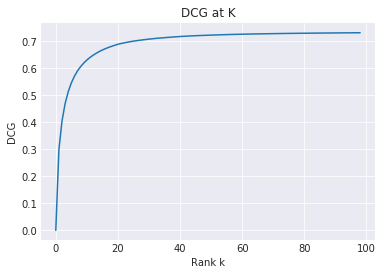

,UserID,DocumentID,DocumentPosition,DocumentURL,EventID,ID,SearchTypeID,ShortTimeStamp,TimeStamp,SearchText
0,72,24292837,1,https://zoek.officielebekendmakingen.nl/blg-80...,27,4833c100-8e0f-401b-9e7a-4d09e1e32f49,14.0,20190625,2019-06-25T13:46:44.934Z,"""Natuurgrond vrijstelling overdrachtsbelasting"""
1,72,32145125,1,https://zoek.officielebekendmakingen.nl/kst-88...,27,6c730341-352f-4fc5-bcde-59ebfe4ef602,14.0,20190625,2019-06-25T13:47:41.646Z,*
2,448,4389594,4,https://www.navigator.nl/#/document/inod94d82b...,27,ea4e2d6b-0f5c-4478-8efc-f411506b9906,14.0,20190602,2019-06-02T15:45:26.404Z,renovatie huurverhoging
3,448,"[7166612, 4389858, 4389864]","[4, 2, 1]",[https://www.navigator.nl/#/document/id6a1457c...,27,0817d96a-a500-421b-9147-026191c2b7e3,14.0,20190602,2019-06-02T15:47:53.817Z,renovatie huurverhoging artikel 7:255 BW
4,448,"[21501751, 4704583]","[1, 3]",[https://www.navigator.nl/#/document/idpassfc6...,27,65f3adb3-1b64-44ab-a8ec-34fe5cf7a9ae,14.0,20190603,2019-06-03T12:11:32.579Z,JBPR 2010 29
5,448,3990022,1,http://www.legalintelligence.com/documents/loc...,27,4a4a00e1-d6a6-4725-86a9-eca3d5121db4,14.0,20190603,2019-06-03T12:12:17.267Z,JBPR 2010/29
6,448,21501810,4,https://www.navigator.nl/#/document/idpass519b...,27,11490567-2a10-4d70-9f99-985a4dcd30aa,14.0,20190603,2019-06-03T14:14:41.842Z,artikel 551 Rv
7,448,"[3990051, 1371273, 4686030]","[7, 8, 28]",[http://www.legalintelligence.com/documents/lo...,27,9281de9c-2f84-4ff5-9688-1aa7c995f981,14.0,20190603,2019-06-03T14:39:37.562Z,artikel 551 Rv conservatoir
8,448,"[12574714, 15267093, 28507836, 25246114, 42035...","[8, 2, 13, 20, 18, 11]",[http://www.legalintelligence.com/documents/lo...,27,705bab97-2a85-4194-9127-15859fd80e72,14.0,20190603,2019-06-03T12:51:30.526Z,beslag hypotheekrecht misbruik
9,448,"[28328182, 25787931, 21579684]","[4, 11, 18]",[http://deeplink.rechtspraak.nl/uitspraak?id=E...,27,14c364c5-fa99-49d0-91e7-0e69546a3b38,14.0,20190603,2019-06-03T13:01:06.387Z,beslag misbruik van bevoegdheid


,SearchText,count
0,lexicon,165
1,zonnepanelen,82
2,wpnr,61
3,Formele en materiële procesleiding: over botse...,57
4,oplichtingsmiddelen,55
5,wet arbeidsmarkt in balans,49
6,notamail,48
7,haviltex,47
8,avg,46
9,AVG,45


In [42]:
def main() -> pd.DataFrame:
    """
    Start the workflow:
    1. Download the required dataframe, aggregated the proper clicks together calculate a dcg score 
    Return DataFrame
    """
    
    print("Getting dataframe: ")
    df = get_27_frame(rows=100000000, from_disk=True)
    print("Loaded dataframe")
    
    df = aggregate_dataframe(df)
    
    counter = df.groupby(['SearchText']).size().sort_values(ascending=False).reset_index(name='count')
    
    display(df)
    display(counter)
        
    predictions = make_predictions(df)
    average_at_k =  calculate_ndcg(predictions, 100)
    plot_dcg_curve(average_at_k)
    return df

df =  main()
df

counter = df.groupby(['SearchText']).size().sort_values(ascending=False).reset_index(name='count')
    
counter


# df.progress_apply(lambda x: [{POS :  ID} for POS,ID in zip(x['DocumentID'],x['DocumentPosition'])], axis=1).tolist()

In [40]:
df2 = df[df['SearchText'] == 'zonnepanelen']
df2

,AppID,CompID,Department,DocumentID,DocumentPosition,DocumentSource,DocumentURL,EventID,FunctionArea,ID,Month,Publisher,Quarter,RunID,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,UserID,Week,Year,_version_
1569548,1,1234,Belastingdienst,27826688,1,BNB,https://www.navigator.nl/#/document/id7f29fa23...,27,NaN,d64a540e-245e-4a57-bac2-15fa6c248d2e,5,Kluwer,2,NaN,zonnepanelen,14.0,20190516,2,2019-05-16T12:19:46.838Z,168907,20,2019,1633691041382006784
1569561,1,1234,NaN,26908412,1,FUTD,http://www.legalintelligence.com/ProtectedCont...,27,NaN,7d7f1756-da12-48ba-8db9-887b64dbb8ed,5,Euroforum,2,NaN,zonnepanelen,14.0,20190516,2,2019-05-16T12:20:20.532Z,218382,20,2019,1633691076754669569
1571072,1,1234,NaN,26908412,1,FUTD,http://www.legalintelligence.com/ProtectedCont...,27,NaN,cae63f05-ea21-4c0a-ae56-62965637eb0c,5,Euroforum,2,NaN,zonnepanelen,14.0,20190516,2,2019-05-16T12:18:01.257Z,218382,20,2019,1633690930671255552
1572464,1,1234,Belastingdienst,27826688,1,BNB,https://www.navigator.nl/#/document/id7f29fa23...,27,NaN,cdd8b679-d97f-4307-9a2d-322e43b92c95,5,Kluwer,2,NaN,zonnepanelen,14.0,20190516,2,2019-05-16T12:24:41.440Z,185335,20,2019,1633691349640282112
1584406,1,1234,Belastingdienst,26908412,1,FUTD,http://www.legalintelligence.com/ProtectedCont...,27,NaN,41faf375-a031-4256-8b6b-88047d5f4ccb,5,Euroforum,2,NaN,zonnepanelen,14.0,20190516,2,2019-05-16T12:09:30.879Z,83059,20,2019,1633690395491696640
1584420,1,1234,NaN,25792781,1,EU Curia,http://curia.europa.eu/juris/document/document...,27,NaN,4b08966b-9647-4e5f-a6d9-dbfa595fe285,5,Diversen,2,NaN,zonnepanelen,14.0,20190516,2,2019-05-16T12:09:52.142Z,220494,20,2019,1633690417788616704
1755214,1,1234,NaN,31848329,1,FED,https://www.navigator.nl/#/document/id9f20a713...,27,NaN,eaae98c7-49d3-41fa-9ca4-5b3afc63c2fb,5,Kluwer,2,NaN,zonnepanelen,14.0,20190520,2,2019-05-20T08:55:05.332Z,233018,21,2019,1634040550744129536
1755388,1,1234,NaN,26908412,2,FUTD,http://www.legalintelligence.com/ProtectedCont...,27,NaN,bb139d7e-d647-405e-ac00-4724828b778a,5,Euroforum,2,NaN,zonnepanelen,14.0,20190520,2,2019-05-20T08:51:32.443Z,232652,21,2019,1634040327514882048
1797667,1,1234,Belastingdienst,26908412,1,FUTD,http://www.legalintelligence.com/ProtectedCont...,27,NaN,77ebaa61-09cf-4429-9a9b-e5d5ba5fc52d,5,Euroforum,2,NaN,zonnepanelen,14.0,20190529,2,2019-05-29T08:26:37.152Z,165764,22,2019,1634854132620722176
1798555,1,457,NaN,31915570,4,VN Vandaag,https://www.navigator.nl/#/document/idpass64ba...,27,NaN,84e24721-2a32-4f91-b018-7f6ed44453b7,5,Kluwer,2,NaN,zonnepanelen,14.0,20190529,1,2019-05-29T13:46:44.805Z,180769,22,2019,1634874280710766592


In [24]:
docid = df2.iloc[54]['DocumentID']
clicked = df2.iloc[54]['DocumentPosition']
docid
clicked

['21517575',
 '21517574',
 '31008976',
 '31895864',
 '21517575',
 '21517574',
 '21517576',
 '31895864',
 '31008976']

[1, 3, 3, 2, 1, 3, 2, 2, 3]

In [23]:
df = get_27_frame(rows=100000000, from_disk=True)


dat = df[(df['UserID'] == 232969) & (df['SearchText'] == 'oplichtingsmiddelen')]

dat 

,AppID,CompID,Department,DocumentID,DocumentPosition,DocumentSource,DocumentURL,EventID,FunctionArea,ID,Month,Publisher,Quarter,RunID,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,UserID,Week,Year,_version_
1790930,1,379,NaN,21517575,1,Handboek Strafzaken,https://www.navigator.nl/#/document/id8348863c...,27,NaN,63a1e2c3-b244-4075-8edc-7654037a7334,5,Kluwer,2,NaN,oplichtingsmiddelen,14.0,20190518,1,2019-05-18T15:50:57.973Z,232969,20,2019,1633885582089256960
1790934,1,379,NaN,21517574,3,Handboek Strafzaken,https://www.navigator.nl/#/document/idf4488f47...,27,NaN,bc596d06-761b-46d7-a44d-c99a6fe77c7c,5,Kluwer,2,NaN,oplichtingsmiddelen,14.0,20190518,1,2019-05-18T15:51:38.987Z,232969,20,2019,1633885582168948736
1790936,1,379,NaN,31008976,3,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,db94c2ed-6fb4-4d9f-80a0-83be1784a5f2,5,Diversen,2,NaN,oplichtingsmiddelen,14.0,20190518,1,2019-05-18T15:50:20.272Z,232969,20,2019,1633885509152407552
1790937,1,379,NaN,31895864,2,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,2d454435-d515-484f-afcd-23079d1a3907,5,Diversen,2,NaN,oplichtingsmiddelen,14.0,20190518,1,2019-05-18T15:50:21.322Z,232969,20,2019,1633885509161844736
1790940,1,379,NaN,21517575,1,Handboek Strafzaken,https://www.navigator.nl/#/document/id8348863c...,27,NaN,f7e11d44-8e80-4c3a-b4ef-d573fdc86ebc,5,Kluwer,2,NaN,oplichtingsmiddelen,14.0,20190518,1,2019-05-18T15:48:55.587Z,232969,20,2019,1633885438684954624
1790942,1,379,NaN,21517574,3,Handboek Strafzaken,https://www.navigator.nl/#/document/idf4488f47...,27,NaN,1d884a8f-1812-413e-b92b-7f4ccbed69d5,5,Kluwer,2,NaN,oplichtingsmiddelen,14.0,20190518,1,2019-05-18T15:48:59.975Z,232969,20,2019,1633885438702780417
1790943,1,379,NaN,21517576,2,Handboek Strafzaken,https://www.navigator.nl/#/document/id7116c390...,27,NaN,68804e71-4202-45a4-a088-9145b1cf85ad,5,Kluwer,2,NaN,oplichtingsmiddelen,14.0,20190518,1,2019-05-18T15:49:09.005Z,232969,20,2019,1633885438728994816
1792624,1,379,NaN,31895864,2,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,51888c2f-e5ed-42fe-bf0b-a38def9f736b,5,Diversen,2,NaN,oplichtingsmiddelen,14.0,20190518,1,2019-05-18T16:37:36.700Z,232969,20,2019,1633888456305278976
1792625,1,379,NaN,31008976,3,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,0af2911a-f4b8-464c-936f-066717a2f433,5,Diversen,2,NaN,oplichtingsmiddelen,14.0,20190518,1,2019-05-18T16:37:39.169Z,232969,20,2019,1633888458895261696


In [43]:
df = get_27_frame(rows=100000000, from_disk=True)


dat = df[(df['UserID'] == 89811) & (df['SearchText'] == 'zonnepanelen')]

dat 

,AppID,CompID,Department,DocumentID,DocumentPosition,DocumentSource,DocumentURL,EventID,FunctionArea,ID,Month,Publisher,Quarter,RunID,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,UserID,Week,Year,_version_
1821215,1,1234,Belastingdienst,27826688,1,BNB,https://www.navigator.nl/#/document/id7f29fa23...,27,NaN,2cbb0fda-00c5-4b01-ac32-3f2e18b752fa,6,Kluwer,2,f474f6c3-bbd7-4396-be88-aff2564e9c44,zonnepanelen,14.0,20190604,2,2019-06-04T08:05:04.495Z,89811,23,2019,1635396389323145216


In [55]:
rows=100
query='EventID:27 AND DocumentPosition:*'


url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
        '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&start=0&wt=json'.format(query,rows)
# 'header'=>"Accept-Encoding: gzip"
response = requests.get(url,stream=True)
# r = requests.head('http://pymotw.com/2/urllib/index.html')
response.headers
# response.headers['content-length']
# '38227'
total_size = int(response.headers.get('content-length', 0));
total_size
# respon

# r = requests.get(url, stream=True)


liste = []
for data in tqdm(response.iter_content(chunk_size=4096)):

liste


{'Content-Type': 'text/plain;charset=utf-8', 'Transfer-Encoding': 'chunked'}

0

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

[123,
 10,
 32,
 32,
 34,
 114,
 101,
 115,
 112,
 111,
 110,
 115,
 101,
 72,
 101,
 97,
 100,
 101,
 114,
 34,
 58,
 123,
 10,
 32,
 32,
 32,
 32,
 34,
 115,
 116,
 97,
 116,
 117,
 115,
 34,
 58,
 48,
 44,
 10,
 32,
 32,
 32,
 32,
 34,
 81,
 84,
 105,
 109,
 101,
 34,
 58,
 48,
 44,
 10,
 32,
 32,
 32,
 32,
 34,
 112,
 97,
 114,
 97,
 109,
 115,
 34,
 58,
 123,
 10,
 32,
 32,
 32,
 32,
 32,
 32,
 34,
 113,
 34,
 58,
 34,
 69,
 118,
 101,
 110,
 116,
 73,
 68,
 58,
 50,
 55,
 32,
 65,
 78,
 68,
 32,
 68,
 111,
 99,
 117,
 109,
 101,
 110,
 116,
 80,
 111,
 115,
 105,
 116,
 105,
 111,
 110,
 58,
 42,
 34,
 44,
 10,
 32,
 32,
 32,
 32,
 32,
 32,
 34,
 105,
 110,
 100,
 101,
 110,
 116,
 34,
 58,
 34,
 111,
 110,
 34,
 44,
 10,
 32,
 32,
 32,
 32,
 32,
 32,
 34,
 115,
 116,
 97,
 114,
 116,
 34,
 58,
 34,
 48,
 34,
 44,
 10,
 32,
 32,
 32,
 32,
 32,
 32,
 34,
 114,
 111,
 119,
 115,
 34,
 58,
 34,
 49,
 48,
 48,
 34,
 44,
 10,
 32,
 32,
 32,
 32,
 32,
 32,
 34,
 119,
 116,
 34,
 58,
 3

In [45]:
url = "http://example.com/bigfile.bin"
# Streaming, so we can iterate over the response.
r = requests.get(url, stream=True)

# Total size in bytes.
total_size = int(r.headers.get('content-length', 0));
total_size

606

In [90]:
import progressbar
import re
# url = "http://example.com/bigfile.bin"

rows=  10

url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
        '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&start=0&wt=json'.format(query,rows)

local_filename = 'test.html'
r = requests.get(url, stream=True)
f = open(local_filename, 'wb')
r.headers

for chunk in tqdm(r.iter_content(chunk_size=4096)):
    f.write(chunk)

# jsonD = json.dumps(f)
# f.close()



{'Content-Type': 'text/plain;charset=utf-8', 'Content-Length': '7059'}

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

4096

2963

UnsupportedOperation: read